In [11]:
from ocpa.algo.predictive_monitoring import factory as predictive_monitoring
from ocpa.algo.predictive_monitoring import tabular, sequential
import networkx as nx
import pandas as pd
from karateclub.graph_embedding import graph2vec
from karateclub import DeepWalk, Walklets
import node2vec 
from collections import Counter

In [15]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory

def load_ocel(path):
    if path.endswith("jsonocel"):
        ocel_file = ocel_import_factory.apply(path)
    elif path.endswith("xmlocel"):
        ocel_file = ocel_import_factory.apply(path)
    else:
        error_msg = "not a valid extension"
        return error_msg
    return ocel_file

In [12]:
def get_process_executions(ocel):
    # default: connected components
    return ocel.process_executions

def get_events_process_exection(ocel, id):
    return ocel.process_executions[id]

def get_objects_process_execution(ocel, id):
    return ocel.process_execution_objects[id]

def get_process_execution_graph(ocel, id):
    return ocel.get_process_execution_graph(id)

def get_variant_process_executions(ocel):
    return ocel.variants_dict()

In [13]:
def remap_nodes(graph):
    node_mapping = dict((node.event_id, i) for i, node in enumerate(graph.nodes))
    return node_mapping

def feature_graphs_to_nx_graphs(feature_graphs):
    graph_list = []
    for feature_graph in feature_graphs:
        #G = nx.DiGraph()
        G = nx.Graph()

        
        for node in feature_graph.nodes:
            G.add_node(node.event_id)

        for edge in feature_graph.edges:
            G.add_edge(edge.source, edge.target)

        graph_list.append(G)

    return graph_list

def perform_graph2vec(graph_list):
    model = graph2vec.Graph2Vec(attributed=True)
    model.fit(graph_list)
    X = model.get_embedding()

    return X

In [14]:
def extract_features(ocel_log, feature_set_event, feature_set_obj, repr):
    extraction = []
    feature_storage = predictive_monitoring.apply(ocel_log, feature_set_event, feature_set_obj)
    extraction.append(feature_storage)
    if repr == 'table':
        table = tabular.construct_table(feature_storage)
        extraction.append(table)
    elif repr == 'sequential':
        sequences = sequential.construct_sequence(feature_storage)
        extraction.append(sequences)
    return extraction

In [ ]:
def construct_object_df(ocel_log):
    object_types = ocel_log.object_types
    df = pd.DataFrame(columns=[type for type in object_types])
    proc_ex = get_process_executions(ocel_log)
    num_pr_ex = len(proc_ex)
    for i in range(0, num_pr_ex):
        execution = proc_ex[i]
        obj = get_objects_process_execution(ocel_log, i)
        obj_count = Counter(elem[0] for elem in obj)
        obj_dict = pd.DataFrame([obj_count])
        df = pd.concat([df, obj_dict], ignore_index=True)
    return df

**Test Feature Extraction**

In [16]:
path = "C:\\Users\\linab\\Documents\\RWTH Aachen\\Studium\\Semester 3\\Process Discovery\\Samples\\p2p-normal.jsonocel"
ocel_log = load_ocel(path)

In [17]:
# Feature extraction
activities = list(set(ocel_log.log.log["event_activity"].tolist()))
feature_set = [(predictive_monitoring.EVENT_REMAINING_TIME, ()),
               (predictive_monitoring.EVENT_ELAPSED_TIME, ())] + \
              [(predictive_monitoring.EVENT_PRECEDING_ACTIVITES, (act,)) for act in activities]


In [18]:
feature_storage = extract_features(ocel_log, feature_set, [], "")[0]

In [20]:
# get first graph
feature_graph = feature_storage.feature_graphs[0]

In [22]:
# print nodes
for node in feature_graph.nodes:
    print(node.event_id)

7
3
8
6
1
4
2
5
0


In [23]:
# print edges source/ target
for edge in feature_graph.edges:
    print(edge.source, edge.target)

3 4
3 6
3 8
6 8
1 2
4 5
2 3
5 7
0 1


In [24]:
# get nx graph
feature_nx_graph = feature_graphs_to_nx_graphs([feature_graph])[0]

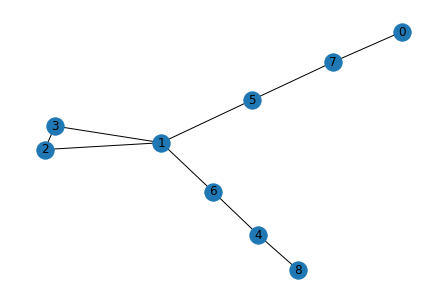

In [26]:
# draw graph
nx.draw(feature_nx_graph, with_labels=True)